In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay, r2_score, mean_squared_error, f1_score
from plotnine import *
import matplotlib.pyplot as plt

In [2]:
cb0 = pd.read_csv("/Users/andriy/Desktop/GSB544_ML/Week_9/Lab_8/cannabis_full.csv").dropna()

In [4]:
cb0.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
(cb0['Type']=='hybrid').sum()

np.int64(1123)

In [6]:
(cb0['Type']=='sativa').sum()

np.int64(409)

In [7]:
(cb0['Type']=='indica').sum()

np.int64(659)

# Part One: Binary Classification

Data

In [8]:
cb0['Type'].unique()

array(['hybrid', 'sativa', 'indica'], dtype=object)

In [4]:
cb1 = cb0.drop(cb0[cb0['Type']=='hybrid'].index)
cb1

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,Zeta-Sage,sativa,4.5,"Happy,Relaxed,Uplifted,Euphoric,Focused","Diesel,Pungent,Sage",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
cb1['Type'].unique()

array(['sativa', 'indica'], dtype=object)

In [11]:
len(cb1['Strain'].unique())
# strain name is unique for every entry, hence it makes sense to remove this from the X feature set in the models - to avoid fitting issues and errors.

1068

In [12]:
len(cb1)

1068

In [13]:
cb1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, 2 to 2350
Data columns (total 69 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Strain        1068 non-null   object 
 1   Type          1068 non-null   object 
 2   Rating        1068 non-null   float64
 3   Effects       1068 non-null   object 
 4   Flavor        1068 non-null   object 
 5   Creative      1068 non-null   float64
 6   Energetic     1068 non-null   float64
 7   Tingly        1068 non-null   float64
 8   Euphoric      1068 non-null   float64
 9   Relaxed       1068 non-null   float64
 10  Aroused       1068 non-null   float64
 11  Happy         1068 non-null   float64
 12  Uplifted      1068 non-null   float64
 13  Hungry        1068 non-null   float64
 14  Talkative     1068 non-null   float64
 15  Giggly        1068 non-null   float64
 16  Focused       1068 non-null   float64
 17  Sleepy        1068 non-null   float64
 18  Dry           1068 non-null   flo

In [5]:
X = cb1.drop(columns=['Strain','Type','Effects','Flavor']) # exclude redundant columns
y = cb1['Type']

In [15]:
X.head()

,Rating,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,4.4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,4.4,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,4.4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Models

## Q1: LDA

In [6]:
# LDA pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lda_pipe = Pipeline([
    ('preprocessing', ct), # note: the dataset is already dummified
    ('lda', LinearDiscriminantAnalysis())
]).set_output(transform="pandas")

In [7]:
# tunning model with multiple parameters # note: assisted by ChatGPT

param_grid = [
    {'lda__solver': ['svd']}, 
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', 0.1, 0.5, 1.0]}
] # note: consider using 'n_components' parameter ranges(1, min(n_classes -1, n_features) with multiclass classification

gsvc = GridSearchCV(lda_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc.fit(X, y)
# as the distribution of differnet 'strain types' is not even, using a harmonized 'f1_weighted' metric to optimize the model and account for class imbalance.

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'}
Best cross-validation score (F1):  0.8662139918046169
Best parameters:  {'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'}
Best cross-validation score (F1):  0.8662139918046169


Best LDA model parameters are:
'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'

Best cross-validation score (F1):  0.8662139918046169

In [8]:
# y_pred with best parameters and cross_val_predict
best_lda = gsvc.best_estimator_
final_fit = best_lda.fit(X, y)
y_pred = final_fit.predict(X)


# scores
print("F1 score (weighted): ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score (weighted):  0.8796088721433537
Accuracy score:  0.8801498127340824
Classification Report:
               precision    recall  f1-score   support

      indica       0.89      0.92      0.90       659
      sativa       0.86      0.82      0.84       409

    accuracy                           0.88      1068
   macro avg       0.88      0.87      0.87      1068
weighted avg       0.88      0.88      0.88      1068

F1 score (weighted):  0.8796088721433537
Accuracy score:  0.8801498127340824
Classification Report:
               precision    recall  f1-score   support

      indica       0.89      0.92      0.90       659
      sativa       0.86      0.82      0.84       409

    accuracy                           0.88      1068
   macro avg       0.88      0.87      0.87      1068
weighted avg       0.88      0.88      0.88      1068



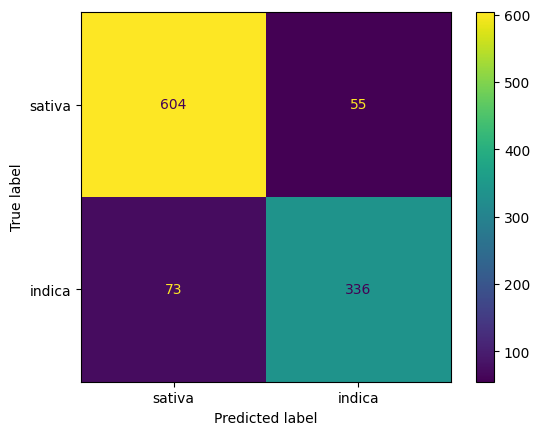

In [9]:
# confusion matrix
cm_best_lda = confusion_matrix(y, y_pred)

labels = cb1['Type'].unique()
ConfusionMatrixDisplay(cm_best_lda, display_labels = labels).plot()

## Q1: QDA

In [10]:
# QDA pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

qda_pipe = Pipeline([
    ('preprocessing', ct), # note: the dataset is already dummified
    ('qda', QuadraticDiscriminantAnalysis())
]).set_output(transform="pandas")

In [11]:
# tunning model with parameters # note: assisted by ChatGPT

param_grid = {
    'qda__reg_param': [0.1, 0.5, 0.7, 0.8, 1.0] # testing different regularization values
    }

gsvc = GridSearchCV(qda_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'qda__reg_param': 1.0}
Best cross-validation score (F1):  0.8636647785510227
Best parameters:  {'qda__reg_param': 1.0}
Best cross-validation score (F1):  0.8636647785510227


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site

Best QDA model parameters:
'qda__reg_param': 1 - meaning model performs best with 'full' regularization, ignoring correlations between features (which may oversimplify the model by ignoring important relationships between features).

Best cross-validation score (F1):  0.8636647785510227

In [12]:
# y_pred with best parameters and cross_val_predict
best_qda = gsvc.best_estimator_
final_fit = best_qda.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score: ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score:  0.8743525762977695
Accuracy score:  0.8745318352059925
Classification Report:
               precision    recall  f1-score   support

      indica       0.89      0.90      0.90       659
      sativa       0.84      0.83      0.83       409

    accuracy                           0.87      1068
   macro avg       0.87      0.87      0.87      1068
weighted avg       0.87      0.87      0.87      1068

F1 score:  0.8743525762977695
Accuracy score:  0.8745318352059925
Classification Report:
               precision    recall  f1-score   support

      indica       0.89      0.90      0.90       659
      sativa       0.84      0.83      0.83       409

    accuracy                           0.87      1068
   macro avg       0.87      0.87      0.87      1068
weighted avg       0.87      0.87      0.87      1068



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear


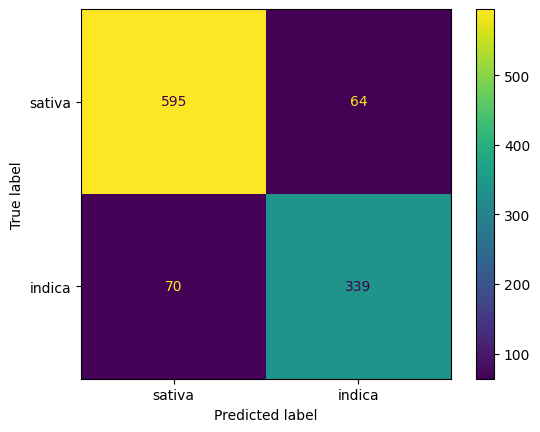

In [13]:
# confusion matrix
cm_best_qda = confusion_matrix(y, y_pred)

labels = cb1['Type'].unique()
ConfusionMatrixDisplay(cm_best_qda, display_labels = labels).plot()

## Q1: SVC

In [14]:
# SVC pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svc_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', SVC(kernel='linear')) # set seed kernel to 'linear', ref: https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html
]).set_output(transform="pandas")

In [15]:
# tunning model # note: assisted by ChatGPT

param_grid={'model__C': [0.01, 0.05, 0.09, 0.1, 0.12, 0.2, 1, 2]}

gsvc = GridSearchCV(svc_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'model__C': 0.09}
Best cross-validation score (F1):  0.8590012298847718
Best parameters:  {'model__C': 0.09}
Best cross-validation score (F1):  0.8590012298847718


Best SVC model parameters:
'model__C': 0.09

Best cross-validation score (F1): 0.8590012298847718

In [16]:
# y_pred with best parameters and cross_val_predict
best_svc = gsvc.best_estimator_
final_fit = best_svc.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score: ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score:  0.8919222281118434
Accuracy score:  0.8923220973782772
Classification Report:
               precision    recall  f1-score   support

      indica       0.90      0.92      0.91       659
      sativa       0.87      0.84      0.86       409

    accuracy                           0.89      1068
   macro avg       0.89      0.88      0.89      1068
weighted avg       0.89      0.89      0.89      1068

F1 score:  0.8919222281118434
Accuracy score:  0.8923220973782772
Classification Report:
               precision    recall  f1-score   support

      indica       0.90      0.92      0.91       659
      sativa       0.87      0.84      0.86       409

    accuracy                           0.89      1068
   macro avg       0.89      0.88      0.89      1068
weighted avg       0.89      0.89      0.89      1068



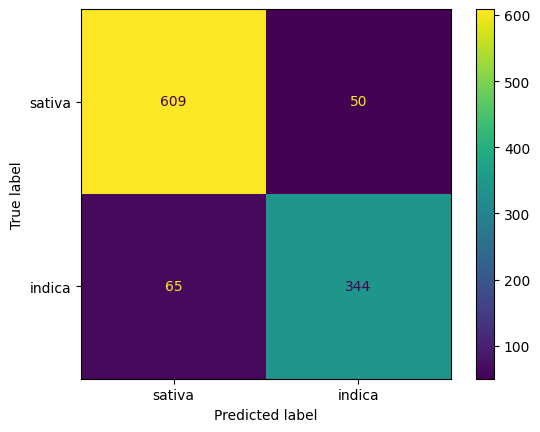

In [17]:
# confusion matrix
cm_best_svc = confusion_matrix(y, y_pred)

labels = cb1['Type'].unique()
ConfusionMatrixDisplay(cm_best_svc, display_labels = labels).plot()

## Q1: SVM

### SVM - Radial

In [18]:
# SVM pipe 1 - Radial

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svm_pipe = Pipeline([
    ('preprocessing', ct),
    ('svm', SVC(kernel='rbf'))
]).set_output(transform="pandas")

In [19]:
# tunning model # note: assisted by ChatGPT

param_grid={
    'svm__C': [0.01, 0.05, 0.09, 0.1, 0.12, 1, 10],  # Regularization coefficient
    'svm__gamma': [1, 0.1, 0.01, 0.001]  # Kernel Coefficient
    }

gsvc = GridSearchCV(svm_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'svm__C': 1, 'svm__gamma': 0.01}
Best cross-validation score (F1):  0.8508115733768248
Best parameters:  {'svm__C': 1, 'svm__gamma': 0.01}
Best cross-validation score (F1):  0.8508115733768248


Best SVM model parameters:
'svm__C': 1, 'svm__gamma': 0.01

Best cross-validation score (F1):  0.8508115733768248

In [20]:
# y_pred with best parameters and cross_val_predict
best_svm = gsvc.best_estimator_
final_fit = best_svm.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score: ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score:  0.919068404623692
Accuracy score:  0.9194756554307116
Classification Report:
               precision    recall  f1-score   support

      indica       0.92      0.95      0.94       659
      sativa       0.92      0.87      0.89       409

    accuracy                           0.92      1068
   macro avg       0.92      0.91      0.91      1068
weighted avg       0.92      0.92      0.92      1068

F1 score:  0.919068404623692
Accuracy score:  0.9194756554307116
Classification Report:
               precision    recall  f1-score   support

      indica       0.92      0.95      0.94       659
      sativa       0.92      0.87      0.89       409

    accuracy                           0.92      1068
   macro avg       0.92      0.91      0.91      1068
weighted avg       0.92      0.92      0.92      1068



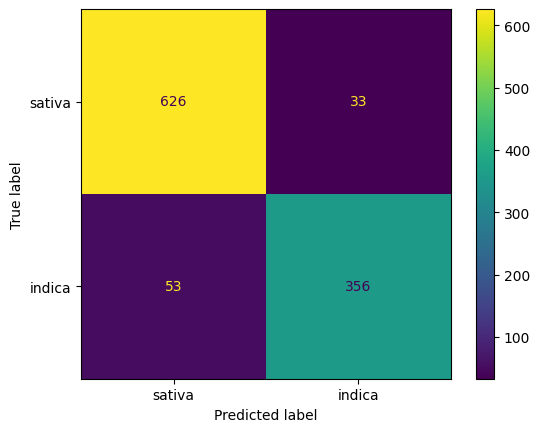

In [21]:
# confusion matrix
cm_best_svm = confusion_matrix(y, y_pred)

labels = cb1['Type'].unique()
ConfusionMatrixDisplay(cm_best_svm, display_labels = labels).plot()

### SVM - Polynomial

In [22]:
# SVM pipe 2 - Polynomial

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svm_pipe = Pipeline([
    ('preprocessing', ct),
    ('svm', SVC(kernel='poly'))
]).set_output(transform="pandas")

In [23]:
# tunning model # note: assisted by ChatGPT

param_grid={
    'svm__C': [0.01, 0.05, 0.09, 0.1, 0.12, 1, 10],  # Regularization coefficient
    'svm__degree': [2, 3, 4, 5],  # Polynomial degree
    'svm__coef0': [0.0, 0.5, 1, 2, 3, 5],  # Independent term
    'svm__gamma': ['scale', 'auto']  # Kernel Coefficient
    }

gsvc = GridSearchCV(svm_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'svm__C': 0.09, 'svm__coef0': 2, 'svm__degree': 4, 'svm__gamma': 'scale'}
Best cross-validation score (F1):  0.8675865700927414
Best parameters:  {'svm__C': 0.09, 'svm__coef0': 2, 'svm__degree': 4, 'svm__gamma': 'scale'}
Best cross-validation score (F1):  0.8675865700927414


Best SVM model parameters:
'svm__C': 0.09, 'svm__coef0': 2, 'svm__degree': 4, 'svm__gamma': 'scale'

Best cross-validation score (F1):  0.8675865700927414

In [24]:
# y_pred with best parameters and cross_val_predict
best_svm = gsvc.best_estimator_
final_fit = best_svm.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score: ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score:  0.9615462170785924
Accuracy score:  0.9616104868913857
Classification Report:
               precision    recall  f1-score   support

      indica       0.96      0.97      0.97       659
      sativa       0.96      0.94      0.95       409

    accuracy                           0.96      1068
   macro avg       0.96      0.96      0.96      1068
weighted avg       0.96      0.96      0.96      1068

F1 score:  0.9615462170785924
Accuracy score:  0.9616104868913857
Classification Report:
               precision    recall  f1-score   support

      indica       0.96      0.97      0.97       659
      sativa       0.96      0.94      0.95       409

    accuracy                           0.96      1068
   macro avg       0.96      0.96      0.96      1068
weighted avg       0.96      0.96      0.96      1068



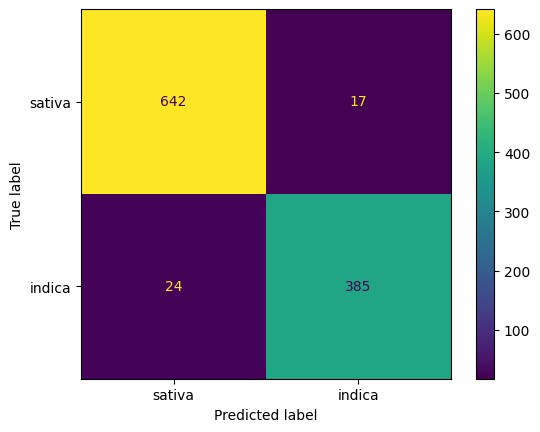

In [25]:
# confusion matrix
cm_best_svm = confusion_matrix(y, y_pred)

labels = cb1['Type'].unique()
ConfusionMatrixDisplay(cm_best_svm, display_labels = labels).plot()

SVM model choice: between the two tuned 'Radial' and 'Polynomial' SVM models tested, the 'Polynomial SVM model' scored slightly better than the 'Radial' model.

# Part Two: Natural Multiclass

Data

In [26]:
# include all straing types from cb0
X = cb0.drop(columns=['Strain','Type','Effects','Flavor']) # exclude redundant columns
y = cb0['Type']

Models

## Q1: Decision Tree

In [27]:
# Decision Tree pipe

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
    make_column_selector(dtype_include=object))
   # ("standardize",  # no need to standarize in a Decision Tree model
   # StandardScaler(),
   # make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

tree_pipe = Pipeline(
  [("preprocessing", ct),
  ("tree", DecisionTreeClassifier())]
).set_output(transform="pandas")

In [28]:
# tunning model with multiple parameters # note: assisted by ChatGPT

param_grid = {
    'tree__min_samples_leaf': [1, 2, 3, 5],
    'tree__max_depth': [2, 3, 4, 5],
    'tree__ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.10],
    'tree__min_impurity_decrease': [0.0, 0.01, 0.05]
}

gsvc = GridSearchCV(tree_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc.fit(X, y)


print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score: ", gsvc.best_score_)

Best parameters:  {'tree__ccp_alpha': 0.0, 'tree__max_depth': 3, 'tree__min_impurity_decrease': 0.0, 'tree__min_samples_leaf': 1}
Best cross-validation score:  0.6144876566697293
Best parameters:  {'tree__ccp_alpha': 0.0, 'tree__max_depth': 3, 'tree__min_impurity_decrease': 0.0, 'tree__min_samples_leaf': 1}
Best cross-validation score:  0.6144876566697293


Best LDA model parameters are:
'tree__ccp_alpha': 0.0, 'tree__max_depth': 3, 'tree__min_impurity_decrease': 0.0, 'tree__min_samples_leaf': 1

Best cross-validation score (F1):  0.6144876566697293

In [29]:
# y_pred with best dt cross_val_predict
best_tree = gsvc.best_estimator_
final_fit = best_tree.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score: ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score:  0.62850244027288
Accuracy score:  0.6335006846188955
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.64      0.72      0.68      1123
      indica       0.67      0.63      0.65       659
      sativa       0.54      0.41      0.47       409

    accuracy                           0.63      2191
   macro avg       0.62      0.59      0.60      2191
weighted avg       0.63      0.63      0.63      2191

F1 score:  0.62850244027288
Accuracy score:  0.6335006846188955
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.64      0.72      0.68      1123
      indica       0.67      0.63      0.65       659
      sativa       0.54      0.41      0.47       409

    accuracy                           0.63      2191
   macro avg       0.62      0.59      0.60      2191
weighted avg       0.63      0.63      0.63      2191



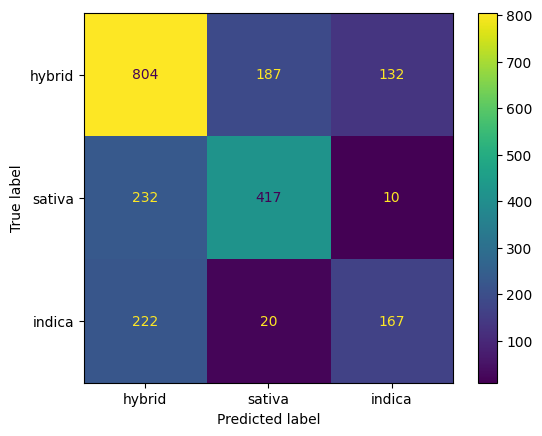

In [30]:
# confusion matrix
cm_best_tree = confusion_matrix(y, y_pred)

labels = cb0['Type'].unique()
ConfusionMatrixDisplay(cm_best_tree, display_labels = labels).plot()

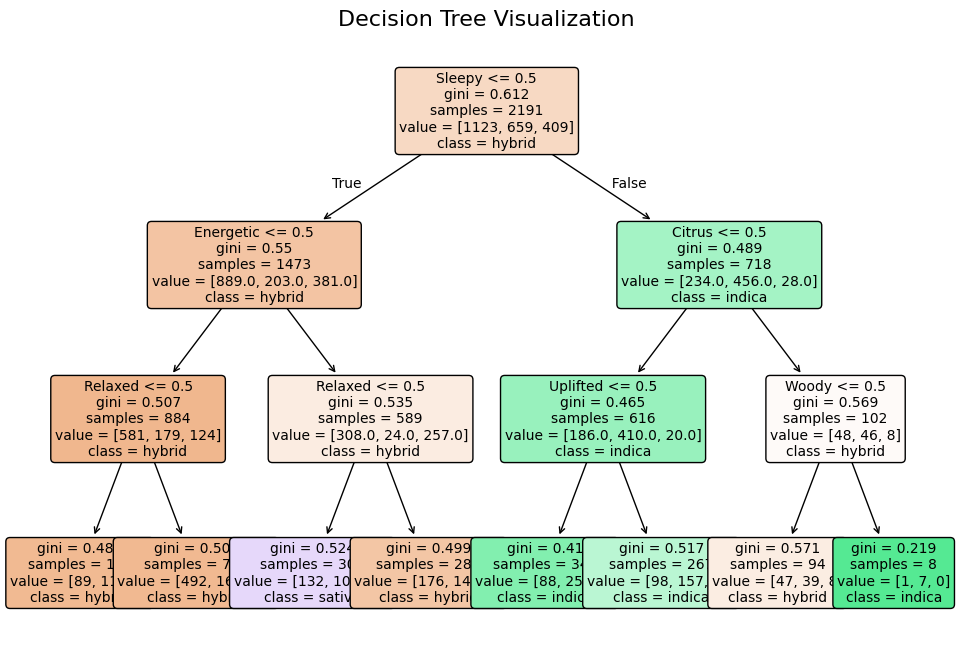

In [31]:
# Plot best decision tree # Assissted by ChatGPT
b_tree = best_tree.named_steps['tree']

plt.figure(figsize=(12,8))
plot_tree(
    b_tree,
    feature_names = X.columns,
    class_names=[str(cls) for cls in sorted(y.unique())],
    filled=True,
    rounded=True,
    fontsize=10

)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

Interpretation:
For this decision tree model with multiclass, we can see that predictive/classification validity is lower based on the F1-score and other metrics.
Also, looking into the decision tree plot we can notice some inconsistency or 'conflicting' leading 'variables' to reduce impurity at each step. For example 'sleepy', 'relaxed' or 'energetic', 'uplifted' can be quite subjective descriptions. This kind of inaccuracy can also me related to an introduced 'hybrid' class that is essentially a broader mixture of 2 other classes and can have altering effect based on it's composition properties and exposure by respondents, this somewhat 'blur the lines' in this classification task for the model.

## Q2: LDA

In [32]:
# LDA 2 pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lda_pipe = Pipeline([
    ('preprocessing', ct), # note: the dataset is already dummified
    ('lda', LinearDiscriminantAnalysis())
]).set_output(transform="pandas")

In [33]:
# tunning model with multiple parameters # note: assisted by ChatGPT

param_grid = [
    {'lda__solver': ['svd']}, 
    {'lda__solver': ['lsqr', 'eigen'], 'lda__shrinkage': ['auto', 0.1, 0.5, 1.0]}
] # note: consider using 'n_components' parameter ranges(1, min(n_classes -1, n_features) with multiclass classification

gsvc = GridSearchCV(lda_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc.fit(X, y)
# as the distribution of differnet 'strain types' is not even, using a harmonized 'f1_weighted' metric to optimize the model and account for class imbalance.

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'}
Best cross-validation score (F1):  0.6242926529700501
Best parameters:  {'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'}
Best cross-validation score (F1):  0.6242926529700501


Best LDA model parameters are:
'lda__shrinkage': 0.5, 'lda__solver': 'lsqr'

Best cross-validation score (F1):  0.6242926529700501

With a multiclass model, the best parameters are the same as in Part One, but the F1 score is signficantly lower with multi-class.

In [34]:
# y_pred with best parameters and cross_val_predict
best_lda = gsvc.best_estimator_
final_fit = best_lda.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score (weighted): ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score (weighted):  0.6441374088385449
Accuracy score:  0.6462802373345504
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.66      0.68      0.67      1123
      indica       0.67      0.69      0.68       659
      sativa       0.54      0.47      0.50       409

    accuracy                           0.65      2191
   macro avg       0.63      0.61      0.62      2191
weighted avg       0.64      0.65      0.64      2191

F1 score (weighted):  0.6441374088385449
Accuracy score:  0.6462802373345504
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.66      0.68      0.67      1123
      indica       0.67      0.69      0.68       659
      sativa       0.54      0.47      0.50       409

    accuracy                           0.65      2191
   macro avg       0.63      0.61      0.62      2191
weighted avg       0.64      0.65      0.64      2191



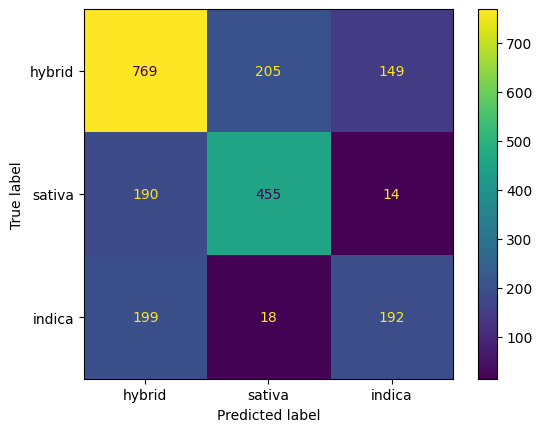

In [35]:
# confusion matrix
cm_best_lda = confusion_matrix(y, y_pred)

labels = cb0['Type'].unique()
ConfusionMatrixDisplay(cm_best_lda, display_labels = labels).plot()

The classification validity has decreased in this case with multiclass LDA.

## Q2: QDA

In [36]:
# QDA pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

qda_pipe = Pipeline([
    ('preprocessing', ct), # note: the dataset is already dummified
    ('qda', QuadraticDiscriminantAnalysis())
]).set_output(transform="pandas")

In [37]:
# tunning model with parameters # note: assisted by ChatGPT

param_grid = {
    'qda__reg_param': [0.1, 0.5, 0.7, 0.8, 1.0] # testing different regularization values
    }

gsvc = GridSearchCV(qda_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site

Best parameters:  {'qda__reg_param': 1.0}
Best cross-validation score (F1):  0.6185440813533856
Best parameters:  {'qda__reg_param': 1.0}
Best cross-validation score (F1):  0.6185440813533856


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear


Best QDA model parameters:
'qda__reg_param': 1 - meaning model performs best with 'full' regularization, ignoring correlations between features (which may oversimplify the model by ignoring important relationships between features).

Best cross-validation score (F1):  0.6185440813533856

In [38]:
# y_pred with best parameters and cross_val_predict
best_qda = gsvc.best_estimator_
final_fit = best_qda.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score: ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score:  0.6412335687063072
Accuracy score:  0.641259698767686
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.67      0.65      0.66      1123
      indica       0.67      0.70      0.69       659
      sativa       0.51      0.52      0.52       409

    accuracy                           0.64      2191
   macro avg       0.62      0.62      0.62      2191
weighted avg       0.64      0.64      0.64      2191

F1 score:  0.6412335687063072
Accuracy score:  0.641259698767686
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.67      0.65      0.66      1123
      indica       0.67      0.70      0.69       659
      sativa       0.51      0.52      0.52       409

    accuracy                           0.64      2191
   macro avg       0.62      0.62      0.62      2191
weighted avg       0.64      0.64      0.64      2191



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear


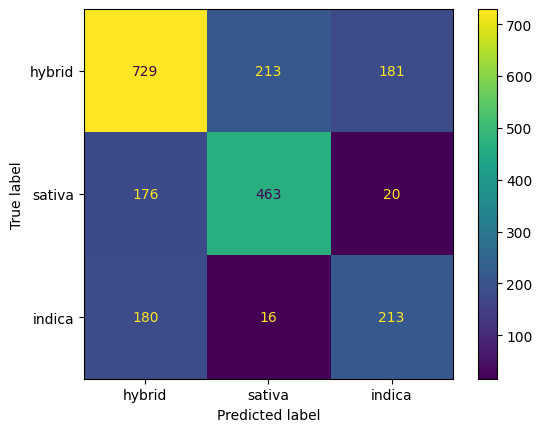

In [39]:
# confusion matrix
cm_best_qda = confusion_matrix(y, y_pred)

labels = cb0['Type'].unique()
ConfusionMatrixDisplay(cm_best_qda, display_labels = labels).plot()

Similar to LDA, the QDA's classification validity has decreased with 3 types multiclass and variables are colliear as marked by the warning.

## Q2: KNN

In [40]:
# KNN pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

knn_pipe = Pipeline([
    ('preprocessing', ct), # note: the dataset is already dummified
    ('knn', KNeighborsClassifier())
]).set_output(transform="pandas")

In [41]:
# tunning model with multiple parameters # note: assisted by ChatGPT

param_grid = {
    'knn__n_neighbors': range(1,30),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'manhattan', 'euclidean'],
    'knn__p': [1, 2]
}

gsvc = GridSearchCV(knn_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'knn__metric': 'minkowski', 'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'uniform'}
Best cross-validation score (F1):  0.5685904228454346
Best parameters:  {'knn__metric': 'minkowski', 'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'uniform'}
Best cross-validation score (F1):  0.5685904228454346


Best KNN model parameters are:
'knn__metric': 'minkowski', 'knn__n_neighbors': 19, 'knn__p': 1, 'knn__weights': 'uniform'

Best cross-validation score (F1):  0.5685904228454346

In [42]:
# y_pred with best parameters and cross_val_predict
best_knn = gsvc.best_estimator_
final_fit = best_knn.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score (weighted): ", f1_score(y, y_pred, average='weighted'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score (weighted):  0.6031614990304265
Accuracy score:  0.6284801460520311
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.61      0.81      0.70      1123
      indica       0.68      0.58      0.62       659
      sativa       0.61      0.21      0.31       409

    accuracy                           0.63      2191
   macro avg       0.63      0.53      0.54      2191
weighted avg       0.63      0.63      0.60      2191

F1 score (weighted):  0.6031614990304265
Accuracy score:  0.6284801460520311
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.61      0.81      0.70      1123
      indica       0.68      0.58      0.62       659
      sativa       0.61      0.21      0.31       409

    accuracy                           0.63      2191
   macro avg       0.63      0.53      0.54      2191
weighted avg       0.63      0.63      0.60      2191



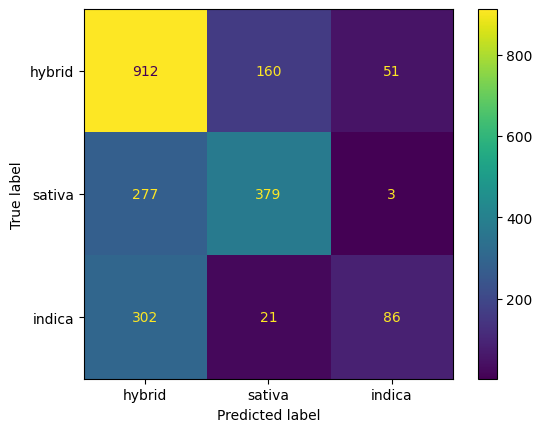

In [43]:
# confusion matrix
cm_best_knn = confusion_matrix(y, y_pred)

labels = cb0['Type'].unique()
ConfusionMatrixDisplay(cm_best_knn, display_labels = labels).plot()

Interestingly, a multi-class best KNN model had the lowest classification validity based on the scores compared to other tuned multi-class models, however it's  performed slightly better on 'hybrid' class in terms of 'recall' comapred to other metrics and models.

## Q3: Multi-class models' metrics evaluation

As mentioned earlier, the overall 'multi-class' classification performance of the above models was substantially lower (compared to 'binary' classification) based on the key metrics, including F1 score.
Overall the average classification validity based onthe F1 score has decreased by approx 20%, which is a big change.
Partial reasoning behind such performance decrease is the introduction of a 'hybrid' target class 'type' which is a mixture of two other classes and may have a broader range of characteristic pertaining to other two class, and hence 'blur' the lines in distinguishing itself from those other two classes in the classification task. Also, this 'hybrid' class has the highest 'weight' by the number of observations in the data.
Generally, between the three 'types', most models had highest scores in classifying 'hybrid' or 'indica' classes, while 'sativa' class scoring was the lowest across all models. 'Sativa' class had also the lowest weight in the dataset, which could affect model's classification accuracy and scores. A good example is the recent classification report for multiclass KNN model, showing 'recall' for 'sativa' class was only 21%, meaning only 21% of true observations were identified as a target class. 
It is also observed in the 'confusion matrices' for all models, where roughly half of 'indica' predictions turned to be 'true hybrids' while approx. half of 'true indica' types where predicted as 'hybrid' (in KNN it was even high disproportion).

Other comments for specific models are made under corresponding confusion matrices.

# Part Three: Multiclass from Binary

Data

In [44]:
# add new columns
cb2 = cb0
cb2['t_Indica'] = (cb2['Type'] == 'indica')*1
cb2['t_Sativa'] = (cb2['Type'] == 'sativa')*1
cb2['t_Hybrid'] = (cb2['Type'] == 'hybrid')*1

In [61]:
cb2.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,t_Indica,t_Sativa,t_Hybrid
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


## Q1. OvR: 'Indica vs. Not Indica'

In [45]:
# define variables

X = cb2.drop(columns=['Strain','Type','Effects','Flavor', 't_Hybrid', 't_Indica', 't_Sativa'])
y = cb2['t_Indica']

Models

### 1: SVC OvR

In [46]:
# SVC pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svc_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', SVC(kernel='linear'))
]).set_output(transform="pandas")

In [47]:
# tunning model # note: assisted by ChatGPT

param_grid={'model__C': [0.01, 0.05, 0.09, 0.1, 0.12, 0.2, 1, 2]}

gsvc = GridSearchCV(svc_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'model__C': 0.01}
Best cross-validation score (F1):  0.792586059609062
Best parameters:  {'model__C': 0.01}
Best cross-validation score (F1):  0.792586059609062


Best SVC model parameters:
'model__C': 0.01

Best cross-validation score (F1): 0.792586059609062

In [48]:
# y_pred with best parameters and cross_val_predict
best_svc = gsvc.best_estimator_
final_fit = best_svc.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.7935393327380208
F1 score m.:  0.7572518114224773
Accuracy score:  0.7914194431766317
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      1532
           1       0.64      0.69      0.67       659

    accuracy                           0.79      2191
   macro avg       0.75      0.76      0.76      2191
weighted avg       0.80      0.79      0.79      2191

F1 score w.:  0.7935393327380208
F1 score m.:  0.7572518114224773
Accuracy score:  0.7914194431766317
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85      1532
           1       0.64      0.69      0.67       659

    accuracy                           0.79      2191
   macro avg       0.75      0.76      0.76      2191
weighted avg       0.80      0.79      0.79      2191



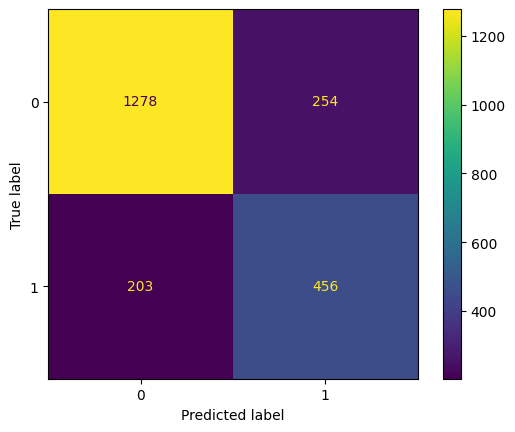

In [49]:
# confusion matrix
cm_best_svc = confusion_matrix(y, y_pred)

labels = cb2['t_Indica'].unique()
ConfusionMatrixDisplay(cm_best_svc, display_labels = labels).plot()

### 1: LogReg OvR

In [50]:
# LogReg pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

logreg_pipe = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression())
]).set_output(transform="pandas")

In [51]:
# tunning model # assisted by ChatGPT

param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs', 'saga']       # Optimization algorithm
}

gsvc = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.7996296283015237
Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.7996296283015237


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
----

Best LogReg model parameters:
'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'

Best cross-validation score (F1): 0.7996296283015237

In [52]:
# y_pred with best parameters and cross_val_predict
best_logreg = gsvc.best_estimator_
final_fit = best_logreg.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.8086452012542528
F1 score m.:  0.7698454665031951
Accuracy score:  0.8110451848471018
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1532
           1       0.70      0.64      0.67       659

    accuracy                           0.81      2191
   macro avg       0.78      0.76      0.77      2191
weighted avg       0.81      0.81      0.81      2191

F1 score w.:  0.8086452012542528
F1 score m.:  0.7698454665031951
Accuracy score:  0.8110451848471018
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1532
           1       0.70      0.64      0.67       659

    accuracy                           0.81      2191
   macro avg       0.78      0.76      0.77      2191
weighted avg       0.81      0.81      0.81      2191



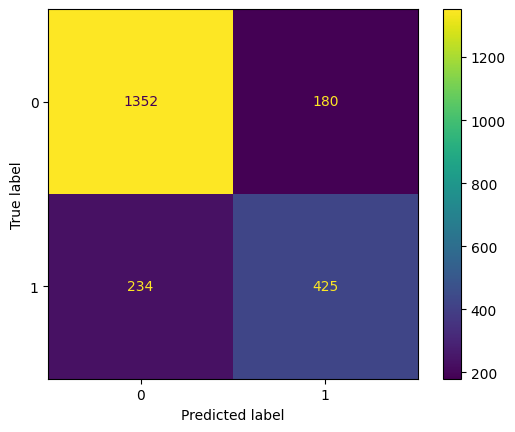

In [53]:
# confusion matrix
cm_best_logreg = confusion_matrix(y, y_pred)

labels = cb2['t_Indica'].unique()
ConfusionMatrixDisplay(cm_best_logreg, display_labels = labels).plot()

## Q1. OvR: 'Sativa vs. Not Sativa'

In [54]:
# define variables

X = cb2.drop(columns=['Strain','Type','Effects','Flavor', 't_Hybrid', 't_Indica', 't_Sativa'])
y = cb2['t_Sativa']

Models

### 2. SVC OvR

In [55]:
# SVC pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svc_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', SVC(kernel='linear'))
]).set_output(transform="pandas")

In [56]:
# tunning model # note: assisted by ChatGPT

param_grid={'model__C': [0.01, 0.05, 0.09, 0.1, 0.12, 0.2, 1, 2]}

gsvc = GridSearchCV(svc_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'model__C': 1}
Best cross-validation score (F1):  0.7845078095327279
Best parameters:  {'model__C': 1}
Best cross-validation score (F1):  0.7845078095327279


Best SVC model parameters:
'model__C': 1 (different tuning parameter than in previous pair)

Best cross-validation score (F1): 0.7845078095327279

In [57]:
# y_pred with best parameters and cross_val_predict
best_svc = gsvc.best_estimator_
final_fit = best_svc.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.7340803087183365
F1 score m.:  0.46049855397138845
Accuracy score:  0.8137836604290278
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90      1782
           1       0.56      0.01      0.02       409

    accuracy                           0.81      2191
   macro avg       0.69      0.50      0.46      2191
weighted avg       0.77      0.81      0.73      2191

F1 score w.:  0.7340803087183365
F1 score m.:  0.46049855397138845
Accuracy score:  0.8137836604290278
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90      1782
           1       0.56      0.01      0.02       409

    accuracy                           0.81      2191
   macro avg       0.69      0.50      0.46      2191
weighted avg       0.77      0.81      0.73      2191



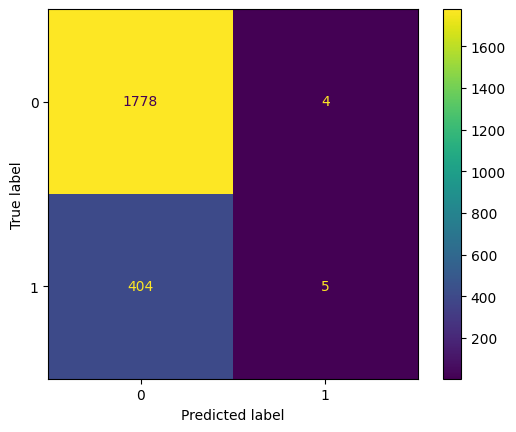

In [58]:
# confusion matrix
cm_best_svc = confusion_matrix(y, y_pred)

labels = cb2['t_Sativa'].unique()
ConfusionMatrixDisplay(cm_best_svc, display_labels = labels).plot()

Note: we can see this model doesn't perform good for predicting the class of interest 'Sativa' and most of the weighted F1 score is contributed by the 'Non-Sativa' classification correctness which dominates the dataset, while F1 score for 'Sativa' prediction is only 0.02! 
I tried applying a simple average 'macro' F1 score and it did look different (approx 0.46 F1 score), however to keep consistency with the prior models, I proceed with applying same 'weighted' F1 score, just being mindful to pay attention to actual between-class scoring validaty for these models.

### 2: LogReg OvR

In [59]:
# LogReg pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

logreg_pipe = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression())
]).set_output(transform="pandas")

In [60]:
# tunning model # assisted by ChatGPT

param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs', 'saga']       # Optimization algorithm
}

gsvc = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 225.
The score on these train-t

Best parameters:  {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.805758310563973
Best parameters:  {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.805758310563973


Best LogReg model parameters:
'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear' (different penalty parameter than in previous pair)

Best cross-validation score (F1): 0.805758310563973

In [61]:
# y_pred with best parameters and cross_val_predict
best_logreg = gsvc.best_estimator_
final_fit = best_logreg.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.822410241253497
F1 score m.:  0.6845496425554316
Accuracy score:  0.8379735280693748
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1782
           1       0.61      0.38      0.46       409

    accuracy                           0.84      2191
   macro avg       0.74      0.66      0.68      2191
weighted avg       0.82      0.84      0.82      2191

F1 score w.:  0.822410241253497
F1 score m.:  0.6845496425554316
Accuracy score:  0.8379735280693748
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      1782
           1       0.61      0.38      0.46       409

    accuracy                           0.84      2191
   macro avg       0.74      0.66      0.68      2191
weighted avg       0.82      0.84      0.82      2191



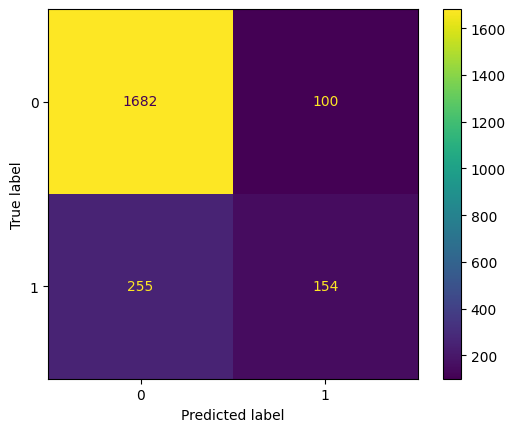

In [63]:
# confusion matrix
cm_best_logreg = confusion_matrix(y, y_pred)

labels = cb2['t_Sativa'].unique()
ConfusionMatrixDisplay(cm_best_logreg, display_labels = labels).plot()

Similarly, with these OvR pair 'Sativa vs. Not Sativa' there is higher spread in (F1 scores) between the '1' (0.46) and '0' (0.90) class type, meaning the model does better at classyfing 'Other' types that the class of interes 'Sativa' in this case, albeit still relatively better than the SVC model on this class pair.

## Q1. OvR: 'Hybrid vs. Not Hybrid'

In [64]:
# define variables

X = cb2.drop(columns=['Strain','Type','Effects','Flavor', 't_Hybrid', 't_Indica', 't_Sativa'])
y = cb2['t_Hybrid']

Models

### 3. SVC OvR

In [65]:
# SVC pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svc_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', SVC(kernel='linear'))
]).set_output(transform="pandas")

In [66]:
# tunning model # note: assisted by ChatGPT

param_grid={'model__C': [0.01, 0.05, 0.09, 0.1, 0.12, 0.2, 1, 2]}

gsvc = GridSearchCV(svc_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'model__C': 0.05}
Best cross-validation score (F1):  0.6108095827161916
Best parameters:  {'model__C': 0.05}
Best cross-validation score (F1):  0.6108095827161916


Best SVC model parameters:
'model__C': 0.5 (different tuning parameter than in previous two pairs)

Best cross-validation score (F1): 0.6108095827161916

In [67]:
# y_pred with best parameters and cross_val_predict
best_svc = gsvc.best_estimator_
final_fit = best_svc.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.6247778910753561
F1 score m.:  0.6232151756196732
Accuracy score:  0.6335006846188955
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.48      0.56      1068
           1       0.61      0.78      0.69      1123

    accuracy                           0.63      2191
   macro avg       0.64      0.63      0.62      2191
weighted avg       0.64      0.63      0.62      2191

F1 score w.:  0.6247778910753561
F1 score m.:  0.6232151756196732
Accuracy score:  0.6335006846188955
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.48      0.56      1068
           1       0.61      0.78      0.69      1123

    accuracy                           0.63      2191
   macro avg       0.64      0.63      0.62      2191
weighted avg       0.64      0.63      0.62      2191



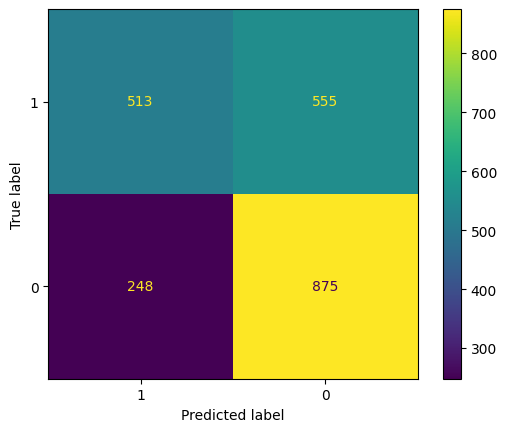

In [68]:
# confusion matrix
cm_best_svc = confusion_matrix(y, y_pred)

labels = cb2['t_Hybrid'].unique()
ConfusionMatrixDisplay(cm_best_svc, display_labels = labels).plot()

Note: Interesting, with this OvR pair 'Hybrid vs. Not Hybrid' the SVC model had a better classification validity for the 'Hybrid' class of interest, compared to 'Other'. However, the scores are not very high.

### 3: LogReg OvR

In [69]:
# LogReg pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

logreg_pipe = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression())
]).set_output(transform="pandas")

In [70]:
# tunning model # assisted by ChatGPT

param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs', 'saga']       # Optimization algorithm
}

gsvc = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.6204234971281153
Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.6204234971281153


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
----

Best LogReg model parameters:
'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear' (different penalty parameter than in previous pair, same as in first pair)

Best cross-validation score (F1): 0.6204234971281153

In [71]:
# y_pred with best parameters and cross_val_predict
best_logreg = gsvc.best_estimator_
final_fit = best_logreg.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.6483243405500168
F1 score m.:  0.6476056749742125
Accuracy score:  0.6499315381104519
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.58      0.62      1068
           1       0.64      0.71      0.68      1123

    accuracy                           0.65      2191
   macro avg       0.65      0.65      0.65      2191
weighted avg       0.65      0.65      0.65      2191

F1 score w.:  0.6483243405500168
F1 score m.:  0.6476056749742125
Accuracy score:  0.6499315381104519
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.58      0.62      1068
           1       0.64      0.71      0.68      1123

    accuracy                           0.65      2191
   macro avg       0.65      0.65      0.65      2191
weighted avg       0.65      0.65      0.65      2191



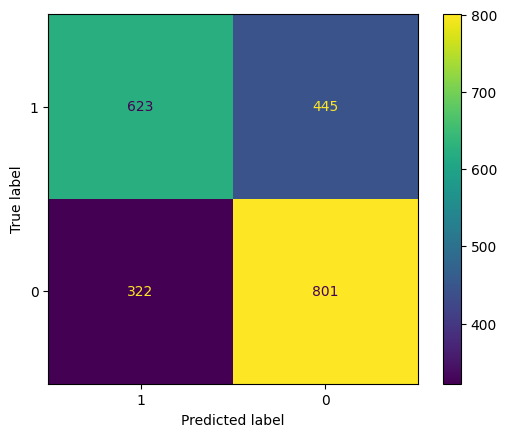

In [72]:
# confusion matrix
cm_best_logreg = confusion_matrix(y, y_pred)

labels = cb2['t_Hybrid'].unique()
ConfusionMatrixDisplay(cm_best_logreg, display_labels = labels).plot()

Similarly to SVC model, with these OvR pair the F1 score is higher for 'Hybrid' vs 'Other' class, however not very high classification validity in general. As we can see the 'weighted' and 'macro' F1 scores converged to similar values, as the 'Hybrid' class the highest weight in the dataset.

## Q2:
Comments for each model provided in previous part under 'confusion matrices' for each model.
Out of 6 OvR models (and 3 class pairs) tested, it's hard to identify which model was significantly better than the other, depedning on which metrics to prioritize, neither performed exceptionally accurate across all metrics. Generally, the first two models SVC and LogReg from 'Indica vs. Not Indica' class type pair had slightly better scores as their corresponding 'class of interest' F1 scores were higher looking at 'class of interest' and simple mean. SVC model in pair 1 had a slightly better 'Recall' score too.

## Q3. OvO: 'Indica vs. Sativa'

Data

In [73]:
# use data set without 'hybrid' type
cb_nh = cb0.drop(cb0[cb0['Type']=='hybrid'].index)
cb_nh.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,t_Indica,t_Sativa,t_Hybrid
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
12,5Th-Element,indica,4.4,"Relaxed,Focused,Euphoric,Uplifted,Aroused","Earthy,Woody,Pine",0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0


In [74]:
cb_nh['Type'].unique()

array(['sativa', 'indica'], dtype=object)

In [75]:
# define variables

X = cb_nh.drop(columns=['Strain','Type','Effects','Flavor', 't_Hybrid', 't_Indica', 't_Sativa'])
y = cb_nh['Type']

Models

### 1: SVC OvO

In [76]:
# SVC pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svc_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', SVC(kernel='linear'))
]).set_output(transform="pandas")

In [77]:
# tunning model # note: assisted by ChatGPT

param_grid={'model__C': [0.01, 0.05, 0.09, 0.1, 0.12, 0.2, 1, 2]}

gsvc = GridSearchCV(svc_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'model__C': 0.09}
Best cross-validation score (F1):  0.8590012298847718
Best parameters:  {'model__C': 0.09}
Best cross-validation score (F1):  0.8590012298847718


Best SVC model parameters:
'model__C': 0.09

Best cross-validation score (F1): 0.8590012298847718

In [78]:
# y_pred with best parameters and cross_val_predict
best_svc = gsvc.best_estimator_
final_fit = best_svc.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.8919222281118434
F1 score m.:  0.8852577403379487
Accuracy score:  0.8923220973782772
Classification Report:
               precision    recall  f1-score   support

      indica       0.90      0.92      0.91       659
      sativa       0.87      0.84      0.86       409

    accuracy                           0.89      1068
   macro avg       0.89      0.88      0.89      1068
weighted avg       0.89      0.89      0.89      1068

F1 score w.:  0.8919222281118434
F1 score m.:  0.8852577403379487
Accuracy score:  0.8923220973782772
Classification Report:
               precision    recall  f1-score   support

      indica       0.90      0.92      0.91       659
      sativa       0.87      0.84      0.86       409

    accuracy                           0.89      1068
   macro avg       0.89      0.88      0.89      1068
weighted avg       0.89      0.89      0.89      1068



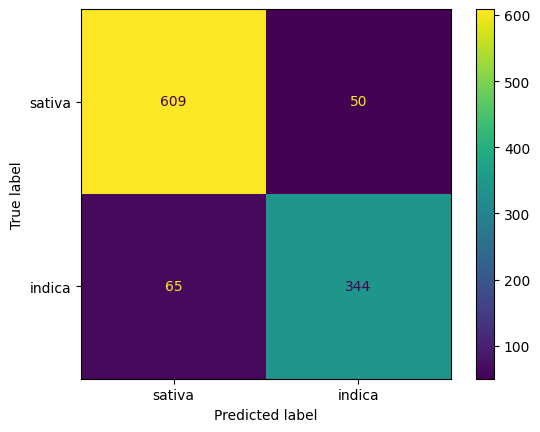

In [79]:
# confusion matrix
cm_best_svc = confusion_matrix(y, y_pred)

labels = cb_nh['Type'].unique()
ConfusionMatrixDisplay(cm_best_svc, display_labels = labels).plot()

For this 1st pair 'Indica vs. Sativa' the model accuracy is noticeably better than with the OvR approach, as noted by the classification scores, including F1 score (also for specific class type). 

### 1: LogReg OvO

In [80]:
# LogReg pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

logreg_pipe = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression())
]).set_output(transform="pandas")

In [81]:
# tunning model # assisted by ChatGPT

param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs', 'saga']       # Optimization algorithm
}

gsvc = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/F

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/F

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best cross-validation score (F1):  0.8695296495154491
Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best cross-validation score (F1):  0.8695296495154491


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/F

Best LogReg model parameters:
'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'saga' (note different solver was prefered in this model, compared to prior versions)

Best cross-validation score (F1): 0.8695296495154491

In [82]:
# y_pred with best parameters and cross_val_predict
best_logreg = gsvc.best_estimator_
final_fit = best_logreg.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.8831124075154975
F1 score m.:  0.8755862193362194
Accuracy score:  0.8838951310861424
Classification Report:
               precision    recall  f1-score   support

      indica       0.89      0.93      0.91       659
      sativa       0.87      0.82      0.84       409

    accuracy                           0.88      1068
   macro avg       0.88      0.87      0.88      1068
weighted avg       0.88      0.88      0.88      1068

F1 score w.:  0.8831124075154975
F1 score m.:  0.8755862193362194
Accuracy score:  0.8838951310861424
Classification Report:
               precision    recall  f1-score   support

      indica       0.89      0.93      0.91       659
      sativa       0.87      0.82      0.84       409

    accuracy                           0.88      1068
   macro avg       0.88      0.87      0.88      1068
weighted avg       0.88      0.88      0.88      1068



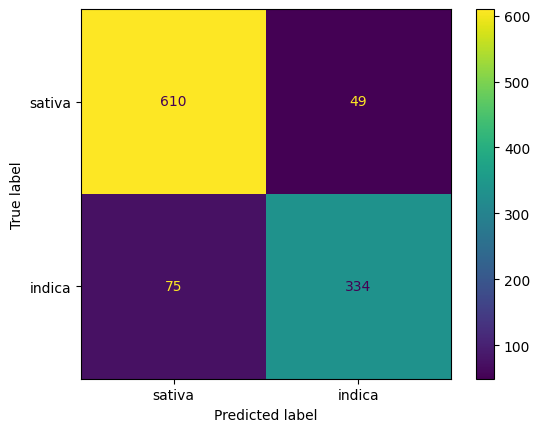

In [83]:
# confusion matrix
cm_best_logreg = confusion_matrix(y, y_pred)

labels = cb_nh['Type'].unique()
ConfusionMatrixDisplay(cm_best_logreg, display_labels = labels).plot()

Similarly to SVC, this OvO pair LogReg model classification validity is substantially higher than with the OvR method, including the F1 scores.

## Q3. OvR: 'Indica vs. Hybrid'

Data

In [84]:
# use data set without 'hybrid' type
cb_ns = cb0.drop(cb0[cb0['Type']=='sativa'].index)
cb_ns.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,t_Indica,t_Sativa,t_Hybrid
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
6,3-Kings,hybrid,4.4,"Relaxed,Euphoric,Happy,Uplifted,Hungry","Earthy,Sweet,Pungent",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [85]:
cb_ns['Type'].unique()

array(['hybrid', 'indica'], dtype=object)

In [86]:
# define variables

X = cb_ns.drop(columns=['Strain','Type','Effects','Flavor', 't_Hybrid', 't_Indica', 't_Sativa'])
y = cb_ns['Type']

Models

### 2. SVC OvR

In [87]:
# SVC pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svc_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', SVC(kernel='linear'))
]).set_output(transform="pandas")

In [88]:
# tunning model # note: assisted by ChatGPT

param_grid={'model__C': [0.01, 0.05, 0.09, 0.1, 0.12, 0.2, 1, 2]}

gsvc = GridSearchCV(svc_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'model__C': 0.05}
Best cross-validation score (F1):  0.758366648354564
Best parameters:  {'model__C': 0.05}
Best cross-validation score (F1):  0.758366648354564


Best SVC model parameters:
'model__C': 0.05 (different tuning parameter than in previous pair)

Best cross-validation score (F1): 0.758366648354564

In [89]:
# y_pred with best parameters and cross_val_predict
best_svc = gsvc.best_estimator_
final_fit = best_svc.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.7595526235849284
F1 score m.:  0.7430316802172021
Accuracy score:  0.7586980920314254
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.82      0.80      0.81      1123
      indica       0.67      0.69      0.68       659

    accuracy                           0.76      1782
   macro avg       0.74      0.74      0.74      1782
weighted avg       0.76      0.76      0.76      1782

F1 score w.:  0.7595526235849284
F1 score m.:  0.7430316802172021
Accuracy score:  0.7586980920314254
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.82      0.80      0.81      1123
      indica       0.67      0.69      0.68       659

    accuracy                           0.76      1782
   macro avg       0.74      0.74      0.74      1782
weighted avg       0.76      0.76      0.76      1782



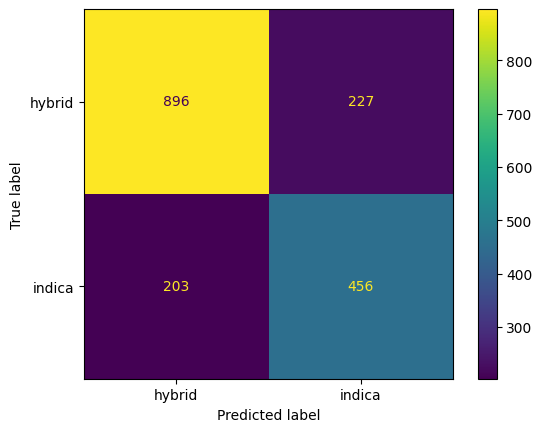

In [90]:
# confusion matrix
cm_best_svc = confusion_matrix(y, y_pred)

labels = cb_ns['Type'].unique()
ConfusionMatrixDisplay(cm_best_svc, display_labels = labels).plot()

With this OvO 'pair' the SVC model accuracy lower than with the previous class pair, however the scores are still better than with the OvR method SVC models.

### 2: LogReg OvR

In [91]:
# LogReg pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

logreg_pipe = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression())
]).set_output(transform="pandas")

In [92]:
# tunning model # assisted by ChatGPT

param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs', 'saga']       # Optimization algorithm
}

gsvc = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.7563355201690969
Best parameters:  {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.7563355201690969


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/

Best LogReg model parameters:
'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear' (different penalty parameter than in previous pair)

Best cross-validation score (F1): 0.7563355201690969

In [93]:
# y_pred with best parameters and cross_val_predict
best_logreg = gsvc.best_estimator_
final_fit = best_logreg.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.7735901786827712
F1 score m.:  0.7562830687830688
Accuracy score:  0.7744107744107744
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.81      0.83      0.82      1123
      indica       0.70      0.68      0.69       659

    accuracy                           0.77      1782
   macro avg       0.76      0.75      0.76      1782
weighted avg       0.77      0.77      0.77      1782

F1 score w.:  0.7735901786827712
F1 score m.:  0.7562830687830688
Accuracy score:  0.7744107744107744
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.81      0.83      0.82      1123
      indica       0.70      0.68      0.69       659

    accuracy                           0.77      1782
   macro avg       0.76      0.75      0.76      1782
weighted avg       0.77      0.77      0.77      1782



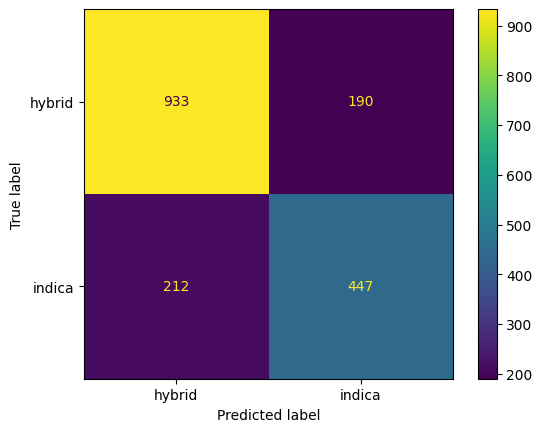

In [94]:
# confusion matrix
cm_best_logreg = confusion_matrix(y, y_pred)

labels = cb_ns['Type'].unique()
ConfusionMatrixDisplay(cm_best_logreg, display_labels = labels).plot()

Similarly to SVC model, with these OvO pair this LogReg model classification performance was slightly lower based on the scores, including F1, however better than in the OvR method.

## Q3. OvR: 'Hybrid vs. Sativa'

Data

In [95]:
# use data set without 'hybrid' type
cb_ni = cb0.drop(cb0[cb0['Type']=='indica'].index)
cb_ni.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear,t_Indica,t_Sativa,t_Hybrid
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [96]:
cb_ni['Type'].unique()

array(['hybrid', 'sativa'], dtype=object)

In [97]:
# define variables

X = cb_ni.drop(columns=['Strain','Type','Effects','Flavor', 't_Hybrid', 't_Indica', 't_Sativa'])
y = cb_ni['Type']

Models

### 3. SVC OvR

In [98]:
# SVC pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

svc_pipe = Pipeline([
    ('preprocessing', ct),
    ('model', SVC(kernel='linear'))
]).set_output(transform="pandas")

In [99]:
# tunning model # note: assisted by ChatGPT

param_grid={'model__C': [0.01, 0.05, 0.09, 0.1, 0.12, 0.2, 1, 2]}

gsvc = GridSearchCV(svc_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

Best parameters:  {'model__C': 2}
Best cross-validation score (F1):  0.7194309277203237
Best parameters:  {'model__C': 2}
Best cross-validation score (F1):  0.7194309277203237


Best SVC model parameters:
'model__C': 2 (different tuning parameter than in previous two pairs)

Best cross-validation score (F1): 0.7194309277203237

In [100]:
# y_pred with best parameters and cross_val_predict
best_svc = gsvc.best_estimator_
final_fit = best_svc.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.7415318165104146
F1 score m.:  0.639707462956112
Accuracy score:  0.7721932114882507
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.79      0.94      0.86      1123
      sativa       0.65      0.31      0.42       409

    accuracy                           0.77      1532
   macro avg       0.72      0.63      0.64      1532
weighted avg       0.75      0.77      0.74      1532

F1 score w.:  0.7415318165104146
F1 score m.:  0.639707462956112
Accuracy score:  0.7721932114882507
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.79      0.94      0.86      1123
      sativa       0.65      0.31      0.42       409

    accuracy                           0.77      1532
   macro avg       0.72      0.63      0.64      1532
weighted avg       0.75      0.77      0.74      1532



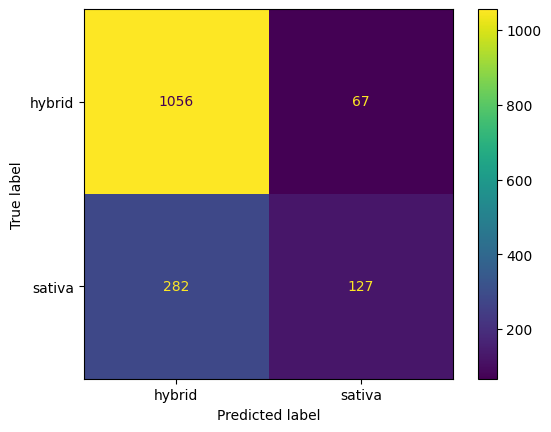

In [101]:
# confusion matrix
cm_best_svc = confusion_matrix(y, y_pred)

labels = cb_ni['Type'].unique()
ConfusionMatrixDisplay(cm_best_svc, display_labels = labels).plot()

Out of all the OvO SVC models, this pair performed the least in terms of classification validity. Higher spread between the type-specific F1 scores and other key metrics.

### 3: LogReg OvO

In [102]:
# LogReg pipe

ct = ColumnTransformer(
  [
#    ("dummify",
#    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop="first"),
#    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

logreg_pipe = Pipeline([
    ('preprocessing', ct),
    ('logreg', LogisticRegression())
]).set_output(transform="pandas")

In [103]:
# tunning model # assisted by ChatGPT

param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet'],  # Regularization type
    'logreg__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'logreg__solver': ['liblinear', 'lbfgs', 'saga']       # Optimization algorithm
}

gsvc = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='f1_weighted')
gsvc_fitted = gsvc.fit(X, y)

print("Best parameters: ", gsvc.best_params_)
print("Best cross-validation score (F1): ", gsvc.best_score_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


Best parameters:  {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.7343357858409283
Best parameters:  {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best cross-validation score (F1):  0.7343357858409283


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/Library/F

Best LogReg model parameters:
'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'

Best cross-validation score (F1): 0.7343357858409283

In [104]:
# y_pred with best parameters and cross_val_predict
best_logreg = gsvc.best_estimator_
final_fit = best_logreg.fit(X, y)
y_pred = final_fit.predict(X)

# scores
print("F1 score w.: ", f1_score(y, y_pred, average='weighted'))
print("F1 score m.: ", f1_score(y, y_pred, average='macro'))
print("Accuracy score: ", accuracy_score(y, y_pred))
print("Classification Report:\n", classification_report(y, y_pred))

F1 score w.:  0.7537262428723476
F1 score m.:  0.6689205523607193
Accuracy score:  0.7689295039164491
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.81      0.90      0.85      1123
      sativa       0.60      0.41      0.49       409

    accuracy                           0.77      1532
   macro avg       0.70      0.66      0.67      1532
weighted avg       0.75      0.77      0.75      1532

F1 score w.:  0.7537262428723476
F1 score m.:  0.6689205523607193
Accuracy score:  0.7689295039164491
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.81      0.90      0.85      1123
      sativa       0.60      0.41      0.49       409

    accuracy                           0.77      1532
   macro avg       0.70      0.66      0.67      1532
weighted avg       0.75      0.77      0.75      1532



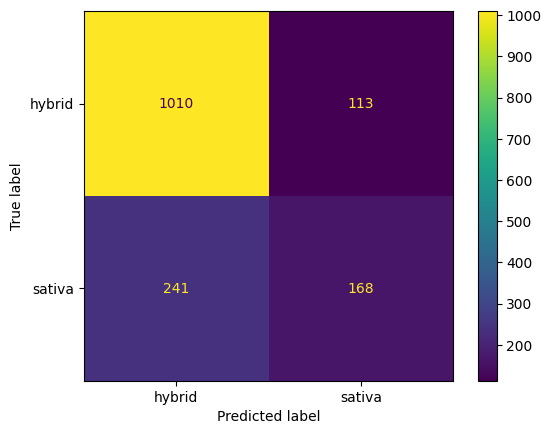

In [105]:
# confusion matrix
cm_best_logreg = confusion_matrix(y, y_pred)

labels = cb_ni['Type'].unique()
ConfusionMatrixDisplay(cm_best_logreg, display_labels = labels).plot()

Similarly to SVC model, this OvO pair LogReg model has lower scores than other OvO pairs, inclduing the F1 score, although slightly higher than for the SVC with this same pair.

## Q4:
Comments for each model provided in previous part under 'confusion matrices' for each model.
Out of 6 OvO models (and 3 class pairs) tested, the SVC with first 'Indica vs. Sativa' class pair has performed best based on the overall classification report and confusion matrix, and the F1 score: 0.8919222281118434. The runner-up model is LogReg on the same class pair.
The lowest performing model is an SVC model on the 3 pair of class types 'Hybrid vs. Sativa' with the highest spread between class scores and lowest F1 score: 0.7415318165104146.

The overall results of these models testing make sense:
- Firstly, the OvO approach on average produced better accuracy scores for models oriented towards 'binary' classifications with two distinct classes (compared to OvR appraoch, where 'all other' classes are mixed toghether).
- Secondly, it is also logical that 'Indica vs. Sativa' OvO pair scored the highest, as these classes are most distinct from each other by their associated qualities ('opposite effects'), hence it was easier for both models to distinguish.
- Thirdly, it also makes sense that the 'Hybrid vs. Sativa' OvO pair scored the lowest accuracy, as a. the 'Hybrid' type is a partial mix of 'Sativa' type and may share similar effects. Also, as Sativa is the smallest and Hybrid is the largest observation samples in the dataset it makes sense why this pair had lower score, amplifying the 'blurred' effect of Hybrid on the models accuracy ("not just on people") - pun intended :)

## Q5:
By default, a 'Logistic Regression' model applies OvR approach on a multi-class dataset (ref. https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html). It is also possible to 'force' and 'OvO' approach with a Logistic Regression model on a multi-class.

The SVC model applies an OvO method on a multi-class data, by default. It is also possible to transform the results into 'OvR' classifier (ref. https://scikit-learn.org/1.5/modules/svm.html).